In [15]:
import openai, time, os, requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from ast import literal_eval
from typing import List, Dict, Any, Optional, Tuple
from UnleashClient import UnleashClient
%matplotlib inline

# Import environment variables 
google_api_key = os.environ.get('GOOGLE_API_KEY')
search_engine_id = os.environ.get('SEARCH_ENGINE_ID')
openai.api_key = os.environ.get('OPENAI_API_KEY')
OPENAI_API_KEY = os.environ.get('OPENAI_API_KEY')

In [3]:
REQUESTS_TIMEOUT = 15
directory = os.getcwd()
MODEL = "gpt-3.5-turbo"

In [23]:
tokens =[]
def get_synonyms_from_open_ai(job_title: str) -> Optional[Dict[str, List[str]]]:
    """
    Get synonyms from OpenAI

    :param job_title: job title
    :return: synonyms
    """

    prompt_system = f"""
    You are a sales person trying to find as many people as possible that perform a certain role at a company. 
    You will receive a json where each key is a single job title. Respond with as many job titles that are 
    synonyms (but no more than 5) to the one received, meaning that people having those job positions perform exactly the same job or 
    their scope of tasks overlap greatly. Include acronyms too even if they duplicate Your existing suggestions.
    Each key has empty list assigned. Fill the list with synonyms.
    Respond in format that is json parsable. Do not explain or comment on your answer.
    """

    headers = {"Authorization": f"Bearer {OPENAI_API_KEY}",
               "Content-Type": "application/json"}
    data = {
        "model": MODEL,
        "messages": [
            {
                "role": "system",
                "content": prompt_system},
            {
                "role": "user",
                "content": str(job_title)
            }
        ],
        "temperature": 0
    }
    try:
        response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers,
                                 json=data, timeout=REQUESTS_TIMEOUT).content.decode("utf-8")
        tokens.append(literal_eval(response)["usage"])
        return literal_eval(literal_eval(response)['choices'][0]['message']['content'])
    except:
        print("Timeout occurred")
        return None


def verify_last_experience(experiences, company_id):
    """
        Verify the last experience of a LinkedIn profile to check if the company ID is present.
    Args:
        experiences (list): A list of experiences from a LinkedIn profile.
        company_id (str): The linkedin company ID to check.

    Returns:
        bool: True if the company ID is present in the last experience, False otherwise.
    """
    last_experience_url = experiences[0]["company_linkedin_profile_url"] if experiences else None
    if last_experience_url:
        return company_id in last_experience_url
    return False


def refine_search_result(search_result: Dict[str, Any]) -> Optional[Dict[str, Any]]:
    """
    Refine a google search result dictionary by extracting the title, link, and snippet.

    Args:
        search_result (dict): The search result dictionary to be refined.

    Returns:
        dict: A dictionary with the refined search result containing title, link, and snippet.
    """
    if all([term in search_result for term in ["title", "link", "snippet"]]):
        return {
            'title': search_result['title'],
            'link': search_result['link'],
            'snippet': search_result['snippet']
        }
    else:
        return None


def perform_google_search(search_query: str) -> Optional[List[Dict[str, Any]]]:
    """
    Perform a Google search using a search query and retrieve filtered search results with only title,link and snippet.

    Args:
        search_query (str): The search query to be used.

    Returns:
        list: A list of dictionaries containing refined search results with title, link, and snippet.
    """
    url = f'https://www.googleapis.com/customsearch/v1?key={google_api_key}&cx={search_engine_id}&q={search_query}'
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        cleaned_results = [refine_search_result(i) for i in data['items']]
        return cleaned_results
    else:
        print(f'Request failed with status code: {response.status_code}')
        return None


def get_answer_from_open_ai(job_title: str, company: str,
                            search_results: List[Dict[str, Any]]) -> Optional[Dict[str, Any]]:
    """
    Retrieve an answer from the OpenAI ChatGPT model using the provided input.

    Args:
        job_title (str): The job title to be used in the prompt.
        company (str): The company name to be used in the prompt.
        max_results (int): The maximum number of results
        search_results (list): A list of dictionaries containing refined search results with title, link, and snippet.

    Returns:
        dict: A dictionary containing one of the search results as the answer.
    """
    prompt_system = f"""
    You are going to receive a list of jsons of real google search results, each with an url to a LinkedIn 
    profile, title and snippet. Your task is assign scores 1-10 to each of the profiles following mechanism:
    1 - very unlikely to be {job_title} at {company}, 10 - very likely to be {job_title} at {company}. You can
    assign the same score to multiple candidates.
    Sort the profiles descending by score and return top 10.
    Do not comment on Your answer or explain it. Your answer must be a json parsable list and each entry
    in the format: 'Score++Full Name++Job title++LinkedIn URL'
    """

    headers = {"Authorization": f"Bearer {OPENAI_API_KEY}",
               "Content-Type": "application/json"}
    data = {
        "model": MODEL,
        "messages": [
            {
                "role": "system",
                "content": prompt_system},
            {
                "role": "user",
                "content": f"Search results: {search_results[:10]}"
            }
        ],
        "temperature": 0
    }

    try:
        response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers,
                                 json=data, timeout=REQUESTS_TIMEOUT).content.decode("utf-8")
        tokens.append(literal_eval(response)["usage"])
        return literal_eval(literal_eval(response)['choices'][0]['message']['content'])
    except:
        print("Timeout occurred")
        return None


def process_row(company: str, job_title: str,
                company_linkedin_profile: str, nb_results: int,
                use_synonym_is_active: bool, linkedin_verify_is_active: bool,get_email_is_active :bool) -> Optional[List[Dict[str, Any]]]:
    """
     Process a single row of data by performing a Google search, filtering the results, and verifying by scraping LinkedIn profiles.

     Args:
         company (str): The company name.
         job_title (str): The job title to search for
         nb_results (int): Max number of results per company
         use_synonym_is_active (bool): A flag to indicate whether to use synonyms or not.
         linkedin_verify_is_active (bool): A flag to indicate whether to verify the last experience of a LinkedIn profile.
         get_email_is_active (bool): A flag to indicate whether to get the email of a person's LinkedIn profile.
     Returns:
         dict: A dictionary containing the relevant information if the candidate is valid, None otherwise.
     """
    # print(f'Processing {company} - {job_title}...')
    
    #get synonym feature flag
    if use_synonym_is_active:
        # get synonyms        
        synonyms_dict = get_synonyms_from_open_ai(job_title)

        # create search query using OR if received a result from OPENAI
        if synonyms_dict and synonyms_dict.get(job_title):
            synonyms = synonyms_dict.get(job_title)
            job_titles_statement = " OR ".join([job_title] + synonyms)
            search_query = "(" + job_titles_statement + ")" + " at " + company + " site:linkedin.com/in/"
        else:
            search_query = job_title + " at " + company + " site:linkedin.com/in/"
    else:
        search_query = job_title + " at " + company + " site:linkedin.com/in/"

    # perform search
    search_results = perform_google_search(search_query=search_query)

    # filter with openai getting scores and sorted
    filtered_results = get_answer_from_open_ai(job_title, company, search_results)
    if not filtered_results:
        return []

    # iterate through candidates:
    #   - scrape linkedin profile
    #   - verify last experience
    #   - if verified return candidate
    #   - else continue to next candidate
    #   - if number of candidates is greater than number of results return candidates
    candidates = []
#     company_id = extract_linkedin_ids(company_linkedin_profile)
    
    for candidate in filtered_results:
        if "None" in candidate: 
            continue
        try:
            score, name, searched_job_title, link = candidate.split("++")
        except ValueError:
            continue
        to_append = True
        if linkedin_verify_is_active: 
            linkedin_profile = scrape_profile(profile=link)
            if linkedin_profile:
                to_append = verify_last_experience(linkedin_profile["experiences"], company_id)
        if to_append:
            candidates.append({
                "score": score,
                "company_name": company,
                "full_name": name,
                "job_title": searched_job_title,
                "person_linkedin_profile": link,
                "emails": scrape_person_email(link) if get_email_is_active else None  
            })
        if len(candidates) == nb_results:
            break
    return candidates


def process_row_wrapper(args: Tuple[str, str, str,int,bool,bool,bool]):
    """
    Wrapper function for process_row to be used with ThreadPoolExecutor.
    """
    return process_row(*args)


def process_data(input_data: pd.DataFrame, job_title: str,nb_results : int) -> pd.DataFrame:
    """
    Process a pandas DataFrame containing company names, LinkedIn profile links, company size, and company location by
    performing a Google search, filtering the results using an LLM, and verifying by scraping LinkedIn profiles.

    Args:
        input_data (pd.DataFrame): A pandas DataFrame containing company names, LinkedIn profile links, company size, and company location.
        job_title (str): The job title to search for.
        nb_results (int): Number of results per company. Default value is 3
    Returns:
        pd.DataFrame: A pandas DataFrame containing the relevant information if the candidate is valid, None otherwise.
    """
    linkedin_verify_is_active = False
    use_synonym_is_active = True
    get_email_is_active = False
    with ThreadPoolExecutor(100) as executor:
        results = list(executor.map(process_row_wrapper,
                                    [(row['company_name'], job_title, row["company_linkedin_profile"],nb_results,use_synonym_is_active,linkedin_verify_is_active,get_email_is_active)
                                     for index, row in input_data.iterrows()]))
    flattened_results = [item for sublist in results for item in sublist]


    # drop None values
    flattened_results = [i for i in flattened_results if i]
    # todo: TBD if we need to add company size and company headquarter as input from the user or scrape it
    # left join to input_data and return result
    if flattened_results:
        out_data = input_data.merge(pd.DataFrame(flattened_results), on="company_name", how="left")
    else:
        out_data = input_data.copy()
        out_data["score"] = None
        out_data["full_name"] = None
        out_data["job_title"] = None
        out_data["person_linkedin_profile"] = None
        out_data["emails"] = None
    return out_data


In [24]:
import pandas as pd
import os
import time

if __name__ == '__main__':
    # You must initialize logging, otherwise you'll not see debug output.
    # Read data from Excel file
    # import data locally
    data = pd.read_excel(os.path.join("../files", "input_data.xlsx"))
    start = time.time()
    # process input data
    output_data = process_data(data, "Head of Development",2)

    print(f"Time taken: {time.time() - start}")



Timeout occurred
Timeout occurred
Timeout occurred
Timeout occurred
Timeout occurred
Timeout occurred
Timeout occurred
Timeout occurred
Timeout occurred
Timeout occurred
Time taken: 33.06698536872864


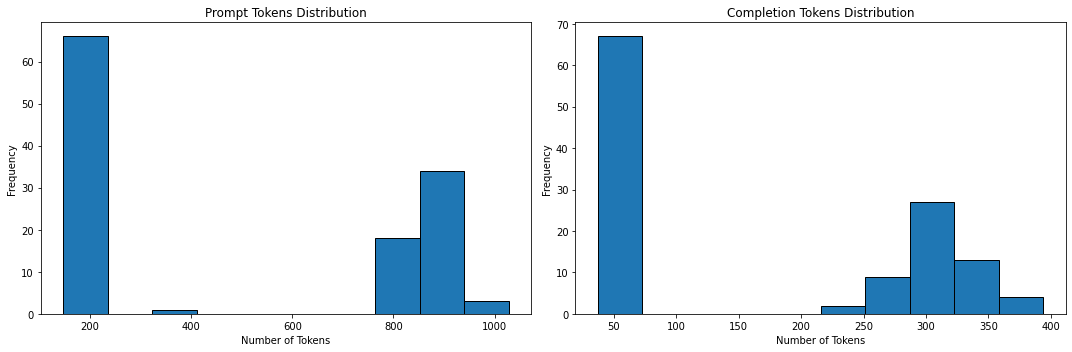

In [27]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

# Your data:
data_list = tokens

# Initialize lists
prompt_tokens = []
completion_tokens = []

# Go through the data list and store tokens
for data in data_list:
    prompt_tokens.append(data["prompt_tokens"])
    completion_tokens.append(data["completion_tokens"])

# Create histograms
fig, axs = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)

# Prompt Tokens Histogram
axs[0].hist(prompt_tokens, bins=10, edgecolor='black')
axs[0].set_title('Prompt Tokens Distribution')
axs[0].set_xlabel('Number of Tokens')
axs[0].set_ylabel('Frequency')

# Completion Tokens Histogram
axs[1].hist(completion_tokens, bins=10, edgecolor='black')
axs[1].set_title('Completion Tokens Distribution')
axs[1].set_xlabel('Number of Tokens')
axs[1].set_ylabel('Frequency')

plt.show()


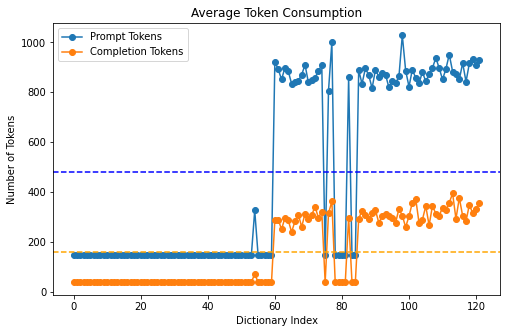

In [28]:
# Initialize lists
prompt_tokens = []
completion_tokens = []

# Go through the data list and store tokens
for data in data_list:
    prompt_tokens.append(data["prompt_tokens"])
    completion_tokens.append(data["completion_tokens"])

# Calculate averages
prompt_avg = np.mean(prompt_tokens)
completion_avg = np.mean(completion_tokens)

# Plot average token consumption
plt.figure(figsize=(8, 5))
plt.plot(prompt_tokens, label='Prompt Tokens', marker='o')
plt.plot(completion_tokens, label='Completion Tokens', marker='o')
plt.axhline(y=prompt_avg, color='blue', linestyle='--')
plt.axhline(y=completion_avg, color='orange', linestyle='--')
plt.title('Average Token Consumption')
plt.xlabel('Dictionary Index')
plt.ylabel('Number of Tokens')
plt.legend()
plt.show()

In [30]:
max(completion_tokens)

394